<a href="https://colab.research.google.com/github/mohripan/CNN-DeepLearning.ai/blob/main/RockPaperScissorsDPAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import h5py
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
!git clone https://github.com/mohripan/CNN-DeepLearning.ai.git

Cloning into 'CNN-DeepLearning.ai'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 123 (delta 3), reused 120 (delta 3), pack-reused 0
Receiving objects: 100% (123/123), 57.78 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
def get_data(batch_size=64):
  train_dataset = h5py.File('/content/CNN-DeepLearning.ai/Convolutional Neural Networks/Week 1/datasets/train_signs.h5', 'r')
  x_train = np.array(train_dataset['train_set_x'][:])
  x_train = np.transpose(x_train, (0, 3, 1, 2))
  y_train = np.array(train_dataset['train_set_y'][:])
  y_train = y_train.reshape((1, y_train.shape[0])).T

  test_dataset = h5py.File('/content/CNN-DeepLearning.ai/Convolutional Neural Networks/Week 1/datasets/test_signs.h5', 'r')
  x_test = np.array(test_dataset['test_set_x'][:])
  x_test = np.transpose(x_test, (0, 3, 1, 2))
  y_test = np.array(test_dataset['test_set_y'][:])
  y_test = y_test.reshape((1, y_test.shape[0])).T

  classes = np.array(test_dataset['list_classes'][:])

  X_train_tensor = torch.tensor(x_train, dtype=torch.float)/255.0
  Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

  X_test_tensor = torch.tensor(x_test, dtype=torch.float)/255.0
  Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

  train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
  test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_dataset, test_dataset, train_loader, test_loader

def path_to_input(image_path, input_size, device):
  img = cv2.imread(image_path)
  img = cv2.resize(img, (input_size, input_size))
  img = img[..., ::-1].transpose((2, 0, 1))
  img = img[np.newaxis, ...]/255.0
  img = torch.tensor(img, dtype=torch.float, device=device)
  return img

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(1)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
train_dataset, test_dataset, train_loader, test_loader = get_data(batch_size=64)

y =  2


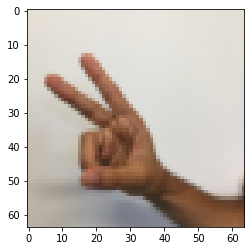

In [9]:
index = 6
img = train_dataset[index][0].numpy().transpose([1, 2, 0])
plt.imshow(img)
print('y = ', str(np.squeeze(train_dataset[index][1].numpy())))

In [10]:
print ("number of training examples =", len(train_dataset))
print ("number of test examples =", len(test_dataset))
print ("shape of a batch of train dataset examples:", next(iter(train_loader))[0].shape)
print ("shape of a batch of train dataset labels:", next(iter(train_loader))[1].shape)

number of training examples = 1080
number of test examples = 120
shape of a batch of train dataset examples: torch.Size([64, 3, 64, 64])
shape of a batch of train dataset labels: torch.Size([64, 1])


In [32]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(2048, 6)
).to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [34]:
def get_accuracy(model, loader):
  model.eval()
  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for idx, (img, labels) in enumerate(loader):
      img, labels = img.to(device), labels.to(device)
      score = model(img)
      _, predicted = score.data.max(1)
      num_samples += predicted.size(0)
      num_correct += (predicted == labels.view(-1)).sum()

  return num_correct.item() / num_samples

In [35]:
def train(model, test_loader, train_loader, epochs=100, print_every=10):
  model.train()
  for i in range(1, epochs+1):
    if i % print_every == 0:
      print(f'Epoch: {i} | Test Accuracy: {get_accuracy(model, test_loader)} | Train Accuracy: {get_accuracy(model, train_loader)}')

    for idx, (img, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      img, labels = img.to(device), labels.to(device)
      score = model(img)
      loss = criterion(score, labels.view(-1))
      loss.backward()
      optimizer.step()

In [36]:
train(model, test_loader, train_loader, epochs=200)

Epoch: 10 | Test Accuracy: 0.31666666666666665 | Train Accuracy: 0.3592592592592593
Epoch: 20 | Test Accuracy: 0.6 | Train Accuracy: 0.6018518518518519
Epoch: 30 | Test Accuracy: 0.7083333333333334 | Train Accuracy: 0.674074074074074
Epoch: 40 | Test Accuracy: 0.775 | Train Accuracy: 0.7722222222222223
Epoch: 50 | Test Accuracy: 0.8083333333333333 | Train Accuracy: 0.8083333333333333
Epoch: 60 | Test Accuracy: 0.825 | Train Accuracy: 0.8342592592592593
Epoch: 70 | Test Accuracy: 0.8833333333333333 | Train Accuracy: 0.8638888888888889
Epoch: 80 | Test Accuracy: 0.85 | Train Accuracy: 0.8601851851851852
Epoch: 90 | Test Accuracy: 0.875 | Train Accuracy: 0.8796296296296297
Epoch: 100 | Test Accuracy: 0.8666666666666667 | Train Accuracy: 0.8870370370370371
Epoch: 110 | Test Accuracy: 0.8916666666666667 | Train Accuracy: 0.8981481481481481
Epoch: 120 | Test Accuracy: 0.8666666666666667 | Train Accuracy: 0.9
Epoch: 130 | Test Accuracy: 0.875 | Train Accuracy: 0.8981481481481481
Epoch: 140 | 

Predicted Class:  5


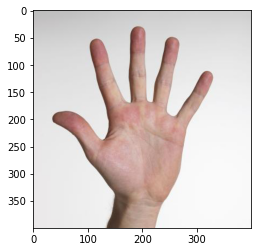

In [38]:
img_path = '/content/CNN-DeepLearning.ai/Convolutional Neural Networks/Week 1/images/5.jpg'
plt.imshow(plt.imread(img_path))

inp = path_to_input(img_path, 64, device)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print('Predicted Class: ', y_pred_cls[0].item())